In [1]:
% matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import glob

import gsw as sw
from mpl_toolkits.basemap import Basemap, cm, interp

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
rcParams.update({'font.family': 'serif'})
rcParams.update({'font.serif': 'Times New Roman'})

/Users/sclayton/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# import mitrate data

argo = pd.read_csv('../data/argo/7546KUROSHIOQC.txt', sep = ',')
argo2 = pd.read_csv('../data/argo/7674KUROSHIOQC.txt', sep = ',')

argo = argo.append(argo2,ignore_index=True)

month = []
for n in range(len(argo)):
    month.append(np.int(str(argo['Date/GMT'][n]).split('/')[0].lstrip('0   ')))

argo['MONTH'] = month


argo = argo[(argo['LON']>140) & (argo['LON']<160) & (argo['LAT']>30) & (argo['LAT']<45)]

print len(argo)

8579


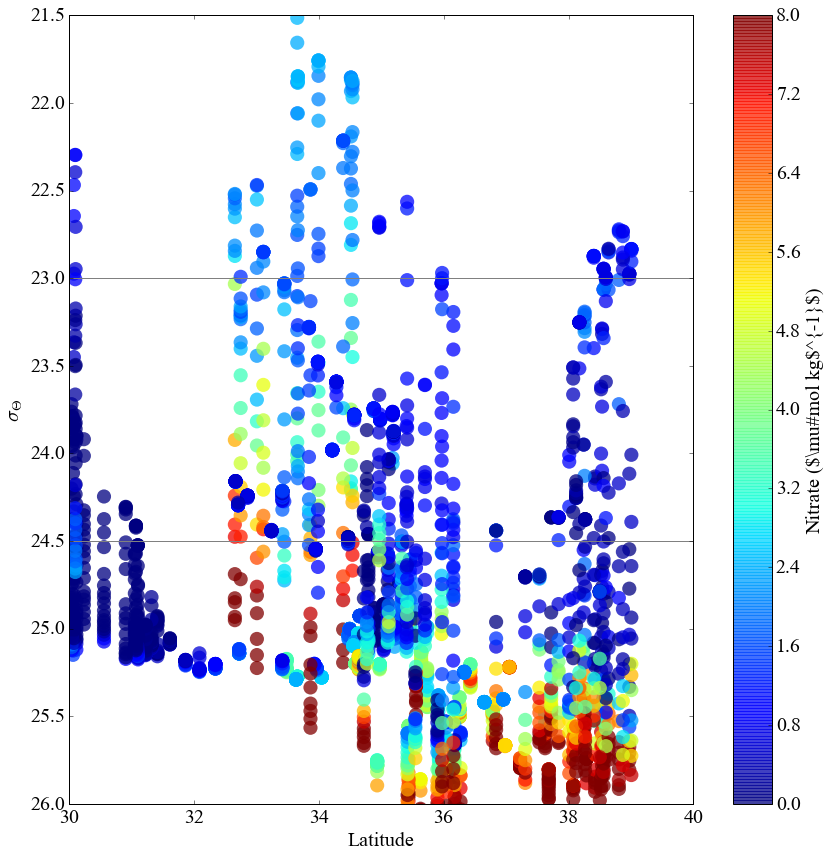

In [27]:
subset = argo[(argo['DEPTH[M]']>=-100)]# & (argo['MONTH']>5) & (argo['MONTH']<9)]
 
fig1 = plt.figure(1, figsize=(12,12))
plt.scatter(subset['LAT'],subset['SIGMA_THETA[KG/M^3]'], c = subset['NITRATE[UMOL/KG]'], s=200, vmin = 0, vmax = 8, lw=0, alpha = 0.75)
#plt.contour()
cb = plt.colorbar()
cb.set_label('Nitrate ($\mu#mol kg$^{-1}$)', fontsize = 20)
plt.gca().invert_yaxis()
plt.axis([ 30,40, 26, 21.5])

plt.axhline(23, color='grey')
plt.axhline(24.5, color='grey') 

plt.ylabel(r'$\sigma_{\Theta}$', fontsize = 20)
plt.xlabel('Latitude', fontsize = 20)
plt.tick_params(labelsize=20)
cb.ax.tick_params(labelsize=20)

plt.show()

#fig1.savefig('../figures/argo_nitrate_sigma_t.png', bbox_inches='tight', dpi=600)

143
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


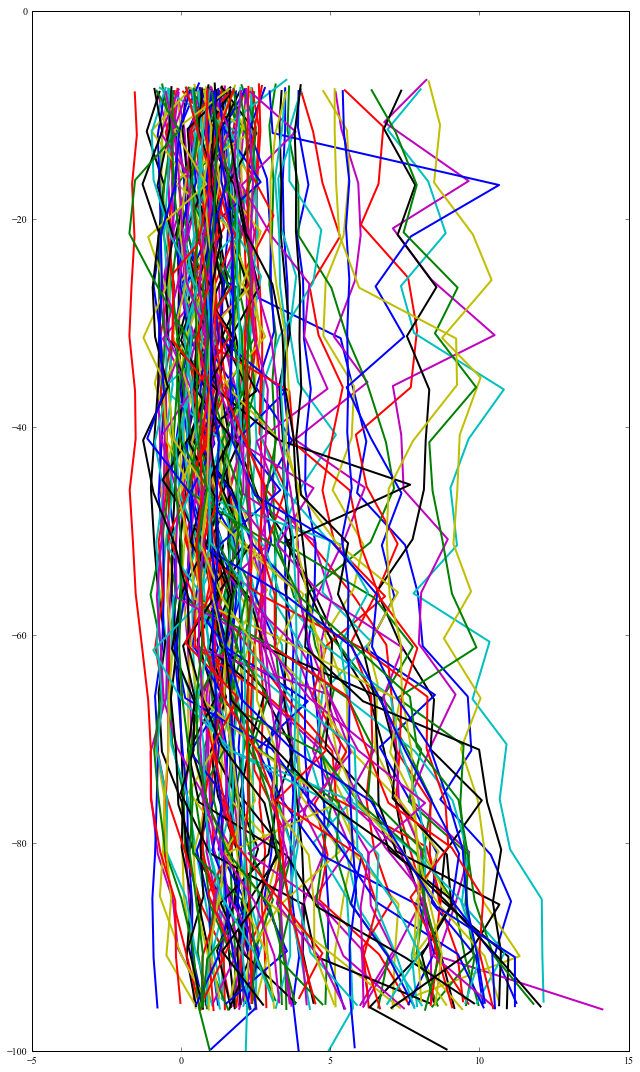

In [4]:
# get may data only
subset = argo[(argo['DEPTH[M]']>=-100)]# & (argo['MONTH']==5)]

days = pd.unique(subset['Days since 1/1/1900'])
print len(days)

fig1 = plt.figure(1, figsize=(9,15))

for d in days:
    subsetd = subset[subset['Days since 1/1/1900']==d]
    print np.max(np.diff(subsetd['NITRATE[UMOL/KG]'].values)/np.diff(subsetd['DEPTH[M]']*-1))>0.005
    
    plt.plot(subsetd['NITRATE[UMOL/KG]'], subsetd['DEPTH[M]'], lw = 2)
plt.axis([-5, 15, -100, 0])
plt.show()